Iniciando entrenamiento de prueba para comprobar que el modelo se puede entrenar. Los valores finales deben ser 1, -1, -1, 1
predicciones iniciales:  [Node(data=0.400022370952216), Node(data=0.5886329558573823), Node(data=0.39129091319092246), Node(data=0.1918375057998331)]
Epoch 0, loss: 1.3681362114883575
Epoch 500, loss: 0.0009970219804706212
Epoch 1000, loss: 0.0004740437109924974
Epoch 1500, loss: 0.0003091258268903207
predicciones finales:  [Node(data=0.998817771532354), Node(data=-0.9849812729078383), Node(data=-0.9761639766897734), Node(data=0.989038863425957)]
x:        self_esteem  sleep_quality  depression  anxiety_level  headache
0              20              2          11             14         2
1               8              1          15             15         5
2              18              2          14             12         2
3              12              1          15             16         4
4              28              5           7             16         2


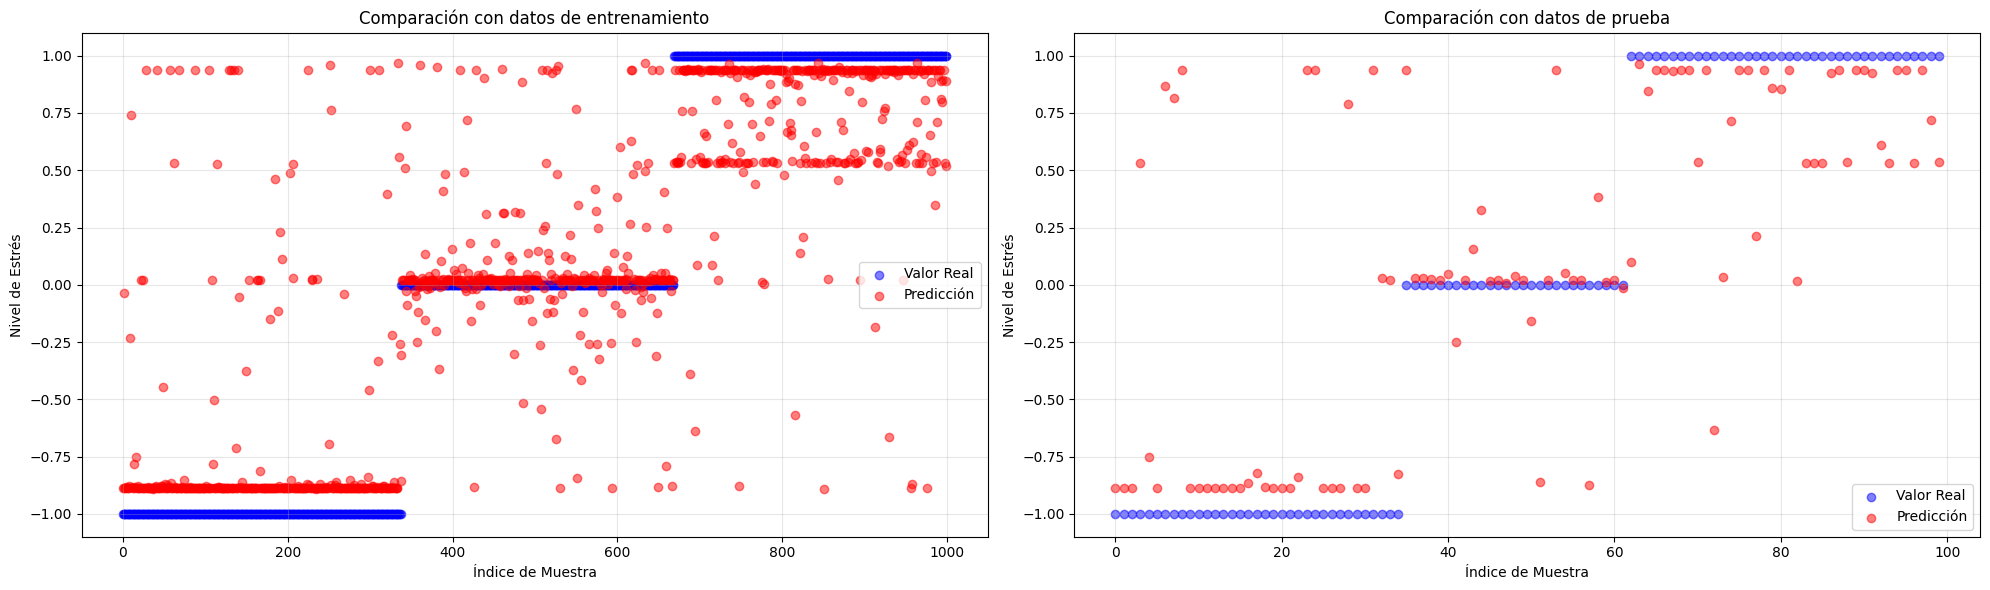

Error cuadrático medio (entrenamiento): 0.1947
Error cuadrático medio (prueba): 0.4173


In [44]:
import math
import random

# Clase para un nodo de un grafo que describe operaciones matemáticas y que es capaz de hacer derivadas parciales.

class Node:

    def __init__(self, data, _children=(), _op='', label=''):

        # Valor numérico del nodo
        self.data= data
        # Operador usado para crear este nodo
        self._op = _op
        # Nombre del nodo (opcional)
        self.label = label
        # Gradiente de la función respecto a este nodo
        self.grad = 0.0
        # Nodos que fueron operados para crear el nodo actual
        self._prev = _children


    # Sobrecarga de operadores para poder hacer operaciones entre nodos.

    def __repr__(self):
        return f"Node(data={self.data})" #, children={self._prev})"
    
    def __add__(self, other):
        out = Node(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Node(self.data * other.data, (self, other), '*')
        return out
    
    def __sub__(self, other):
        out = Node(self.data - other.data, (self, other), '-')
        return out
    
    def __pow__(self, other):
        out = Node(self.data**other.data, (self, other), '**')
        return out

    def __iadd__(self, other):
        total = self.data + other.data
        out = Node(total, (self, other), '+')
        return out
    
    def __truediv__(self, other):
        out = Node(self.data / other.data, (self, other), '/')
        return out

    # Funciones de activación que pueden aplicarse a un nodo.

    def tanh(self):
        x = self.data
        if x > 100:
            x = 100
        elif x < -100:
            x = -100
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Node(t, (self, ), 'TanH')
        return out
    
    def RelU(self):
        x = self.data
        r = max(0, x)
        out = Node(r, (self, ), 'RelU')
        return out
    




    def backward(self):
        self.grad = 1

            # Crear lista topológicamente ordenada
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        # Construir orden topológico
        build_topo(self)

        for node in reversed(topo):
            if node._op == '+':
                for n in node._prev:
                    n.grad += 1.0 * node.grad

            elif node._op == '-':
                node._prev[0].grad += 1.0 * node.grad
                node._prev[1].grad += -1.0 * node.grad

            elif node._op == '*':
                node._prev[0].grad += node._prev[1].data * node.grad
                node._prev[1].grad += node._prev[0].data * node.grad
            
            elif node._op == '**':
                exp = node._prev[1].data
                node._prev[0].grad += exp * (node._prev[0].data ** (exp - 1)) * node.grad
                # recurse(node._prev[1])

            elif node._op == 'TanH':
                node._prev[0].grad += (1 - node.data**2) * node.grad
                # self._prev[0].recurse()

            elif node._op == 'RelU':
                if node.data > 0:
                    node._prev[0].grad += 1 * node.grad
                else:
                    node._prev[0].grad += 0
                # node._prev[0].recurse()
            
            elif node._op == '/':
                node._prev[0].grad += (1/ node._prev[1].data) * node.grad
                node._prev[1].grad += ((-node._prev[0].data) / (node._prev[1].data**2))* node.grad 



# Clase para una neurona de la red neuronal. Usa nodos para representar las operaciones matemáticas que describen la neurona (pesos, bias, suma ponderada, función de activación).

class Neuron:
    def __init__(self, inputs):
        # Lista de pesos (uno por cada entrada)
        self.w = []
        for _ in range(inputs):
            self.w.append(Node(random.uniform(-1, 1)))
        # Bias
        self.b = Node(random.uniform(-1,1))

        # print(self.w, self.b)

    # Regresa los parámetros de la neurona (pesos y bias) como nodos.
    def parameters(self):
        return self.w + [self.b]

    # Al llamar a la neurona con una lista de entradas regresa la salida de la neurona.
    def __call__(self, x):
        # Inicializar el total de la activación sumandole el bias.
        total = Node(self.b.data)

        # Crea pares de peso y entrada.
        for wi, xi in zip(self.w, x):
            # Si la entrada no es un nodo, lo convierte en uno para poderla operar.
            if type(xi) != Node:
                xi = Node(xi)
            # print('weight/input: ', wi, xi)
            # Multiplica el peso por la entrada y lo suma al total.
            activation = wi * xi
            total = total + activation
        # Normaliza la activación de la neurona
        output = total.tanh()

        # out = activation.tanh()
        return output
    


# Clase para una capa de la red neuronal compuesta de varias neuronas. Está completamente conectada a la capa anterior.

class Layer:
    def __init__(self, inputs, outputs):
        # Crea una lista de neuronas correspondiendo con el número de salidas de esa capa. Cada neurona está conectada a todas las entradas.
        self.neurons = []
        for _ in range(outputs):
            self.neurons.append(Neuron(inputs))
    
    # Al llamar la capa con una lista de entradas regresa la salida de cada neurona.
    def __call__(self, x):
        output = []
        for neuron in self.neurons:
            # print('neuron: ', neuron.w, neuron.b)
            output.append(neuron(x))
        return output[0] if len(output) == 1 else output
    
    # Regresa los parámetros de cada neurona de la capa como nodos. No necesita estar ordenada por que cada uno guarda su propio gradiente.
    def parameters(self):
        parameters = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            parameters.extend(ps)
        return parameters
    


# Clase para una red neuronal densa. 

class NN:
    def __init__(self, inputs, layers):
        # Crear una lista con el número de valores por capa incluyendo la entrada para poder crear las capas con el número de entradas y de neuronas correcto. 
        inout = [inputs] + layers 
        self.layers = []

        # Crea capas que tienen el número de entradas = al número de salidas de la capa anterior.
        for i in range(len(layers)):
            self.layers.append(Layer(inout[i], inout[i+1]))
    
    # Al llamar la red neuronal con una lista de entradas regresa la salida de la última capa. Se llama de forma iterativa para ir actualizando los valores desde la primera capa.
    def __call__(self, x):
        for layer in self.layers:
            # print('layer: ', layer)
            x = layer(x)
        return x

    # Regresa lois parámetros de cada neurona de cada capa como nodos.
    def parameters(self):
        parameters = []
        for layer in self.layers:
            ps = layer.parameters()
            parameters.extend(ps)
        return parameters
    



# Red neuronal con 3 entradas, 2 capas de 4 neuronas y 1 neurona de salida.
n = NN(3, [4,4,1])

# Entradas de ejemplo
xs = [[2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0, -1.0]]

# salidas de ejemplo
ys = [1.0, -1.0, -1.0, 1.0]

def predict(network, xs):
    prediction = []
    for x in xs:
        prediction.append(network(x))
    return prediction

ypred = predict(n, xs)

print('Iniciando entrenamiento de prueba para comprobar que el modelo se puede entrenar. Los valores finales deben ser 1, -1, -1, 1')
print( 'predicciones iniciales: ', ypred )

def train(network, xs, ys, epochs=1000, learning_rate=0.01, printability=500):
    for i in range(epochs):

        # Fordward
        ypred = predict(network, xs)
        # Calculo de la pérdida con el error cuadrático.
        loss = Node(0.0)
        for yt, yout in zip(ys, ypred):
            
            # Convert single values to list
            if isinstance(yt, (int, float)):
                yt = [yt]
            
            # Ensure prediction is in correct format
            if not isinstance(yout, list):
                yout = [yout]

            for target, pred in zip(yt, yout):
                loss += (pred - Node(target))**Node(2)
                
        loss = loss * Node(1/len(ys))
        # Backward 
        # Backpropagation calculando el gradiente de la función de pérdida respecto a cada parámetro.
        loss.backward()

        # Update
        for parameter in network.parameters():
            parameter.data += -learning_rate * parameter.grad
            parameter.grad = 0.0
        
        if i % printability == 0:
            print(f"Epoch {i}, loss: {loss.data}")

    

train(n, xs, ys, epochs=2000, learning_rate=0.05)

print('predicciones finales: ', predict(n, xs))




import pandas as pd
df = pd.read_csv('StressLevelDataset.csv')
df.head()


y = df[['stress_level']]
x = df[['self_esteem', 'sleep_quality', 'depression', 'anxiety_level', 'headache']]

# x = df[['anxiety_level', 'self_esteem', 'depression', 'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem', 'noise_level', 'living_conditions', 'safety', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure', 'extracurricular_activities', 'bullying']]


y = y-1 # Normalizar el estres de -1 a 1

def normalize_data(data):
    min_val = data.min()
    max_val = data.max()
    normalized = (((data - min_val) / (max_val - min_val)) * 2) - 1
    return normalized

# x = normalize_data(x)

print('x: ', x)

import numpy as np

Xtrain = np.array(x[:-100])
Xtest = np.array(x[-100:])

Ytrain = np.array(y[:-100])
Ytest = np.array(y[-100:])

X_train_list = Xtrain.tolist()
Y_train_list = Ytrain.tolist()

Y_test_list = Ytest.tolist()
X_test_list = Xtest.tolist()


import sys
sys.setrecursionlimit(100000) # Aumentar el límete de recursión para evitar errores al hacer backpropagation en redes grandes.




stress_predictor = NN(5, [8, 6, 4, 1])
# stress_predictor(X_test_list[7])





print('\n\n\nIniciando entrenamiento real sobre el dataset de estrés hasta 200 iteraciones, puede tomar un tiempo... \n')

train(stress_predictor, X_train_list, Y_train_list, epochs=500, learning_rate=0.005, printability=20) # Printability es cada cuantas iteraciones se imprime el error actual.


import matplotlib.pyplot as plt



# Obtener resultados de train

y_pred_train = []
for x in X_train_list:
    pred = stress_predictor(x)
    # Convertir Node a valor float
    if isinstance(pred, list):
        y_pred_train.append([p.data for p in pred])
    else:
        y_pred_train.append(pred.data)

# Convertir predicciones y valores reales a arrays numpy
y_pred_train = np.array(y_pred_train)
y_true = np.array([yt[0] for yt in Y_train_list])  # Extraer valores de las listas


# Crear índices ordenados basados en los valores reales
indices_ordenados = np.argsort(y_true)

# Reordenar tanto los valores reales como las predicciones
y_true_ordenado = y_true[indices_ordenados]
y_pred_train_ordenado = y_pred_train[indices_ordenados]




# Obtener resultados de test

y_pred_test = []
for x in X_test_list:
    pred = stress_predictor(x)
    # Convertir Node a valor float
    if isinstance(pred, list):
        y_pred_test.append([p.data for p in pred])
    else:
        y_pred_test.append(pred.data)

# Convertir predicciones y valores reales a arrays numpy
y_pred_test = np.array(y_pred_test)
y_true_test = np.array([yt[0] for yt in Y_test_list])  # Extraer valores de las listas

# Crear índices ordenados basados en los valores reales
indices_ordenados = np.argsort(y_true_test)

# Reordenar tanto los valores reales como las predicciones
y_true__test_ordenado = y_true_test[indices_ordenados]
y_pred_test_ordenado = y_pred_test[indices_ordenados]




# Crear una figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Primera gráfica (datos de entrenamiento)
ax1.scatter(range(len(y_true_ordenado)), y_true_ordenado, c='blue', label='Valor Real', alpha=0.5)
ax1.scatter(range(len(y_pred_train_ordenado)), y_pred_train_ordenado, c='red', label='Predicción', alpha=0.5)
ax1.set_xlabel('Índice de Muestra')
ax1.set_ylabel('Nivel de Estrés')
ax1.set_title('Comparación con datos de entrenamiento')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Segunda gráfica (datos de prueba)
ax2.scatter(range(len(y_true__test_ordenado)), y_true__test_ordenado, c='blue', label='Valor Real', alpha=0.5)
ax2.scatter(range(len(y_pred_test_ordenado)), y_pred_test_ordenado, c='red', label='Predicción', alpha=0.5)
ax2.set_xlabel('Índice de Muestra')
ax2.set_ylabel('Nivel de Estrés')
ax2.set_title('Comparación con datos de prueba')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

# Imprimir métricas de error
mse_train = np.mean((y_true - y_pred_train)**2)
mse_test = np.mean((y_true_test - y_pred_test)**2)
print(f"Error cuadrático medio (entrenamiento): {mse_train:.4f}")
print(f"Error cuadrático medio (prueba): {mse_test:.4f}")

In [9]:
import torch
from torch import nn

In [10]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [51]:
# Definir la arquitectura de la red
class StressPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(5, 8),    
            nn.Tanh(),      
            nn.Linear(8, 6),    
            nn.Tanh(), 
            nn.Linear(6, 4),    
            nn.Tanh(), 
            nn.Linear(4, 1),   
            nn.Tanh()          
        )

    def forward(self, x):
        return self.network(x)

In [52]:
model = StressPredictor()
print(model)

StressPredictor(
  (network): Sequential(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=6, bias=True)
    (3): Tanh()
    (4): Linear(in_features=6, out_features=4, bias=True)
    (5): Tanh()
    (6): Linear(in_features=4, out_features=1, bias=True)
    (7): Tanh()
  )
)


In [53]:
# Preparar los datos
def prepare_data(x, y):
    x_tensor = torch.FloatTensor(x)
    y_tensor = torch.FloatTensor(y)
    return torch.utils.data.TensorDataset(x_tensor, y_tensor)

# Cargar y normalizar datos
df = pd.read_csv('StressLevelDataset.csv')
x = df[['self_esteem', 'sleep_quality', 'depression', 'anxiety_level', 'headache']]
y = df[['stress_level']]
y = (y - 1)  # Normalizar estrés a [-1,1]

# Normalizar features
# x = (x - x.min()) / (x.max() - x.min()) * 2 - 1

# Separar train/test
X_train = x[:-100].values
X_test = x[-100:].values
y_train = y[:-100].values
y_test = y[-100:].values

# Crear datasets
train_dataset = prepare_data(X_train, y_train)
test_dataset = prepare_data(X_test, y_test)

# Crear dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

# Inicializar modelo, pérdida y optimizador
model = StressPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [54]:
# Entrenamiento
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')


Epoch [10/200], Loss: 0.1550
Epoch [20/200], Loss: 0.1446
Epoch [30/200], Loss: 0.1332
Epoch [40/200], Loss: 0.1202
Epoch [50/200], Loss: 0.1200
Epoch [60/200], Loss: 0.1158
Epoch [70/200], Loss: 0.1192
Epoch [80/200], Loss: 0.1066
Epoch [90/200], Loss: 0.1075
Epoch [100/200], Loss: 0.1063
Epoch [110/200], Loss: 0.1008
Epoch [120/200], Loss: 0.1049
Epoch [130/200], Loss: 0.1140
Epoch [140/200], Loss: 0.0956
Epoch [150/200], Loss: 0.1004
Epoch [160/200], Loss: 0.1026
Epoch [170/200], Loss: 0.0988
Epoch [180/200], Loss: 0.1052
Epoch [190/200], Loss: 0.1278
Epoch [200/200], Loss: 0.1070


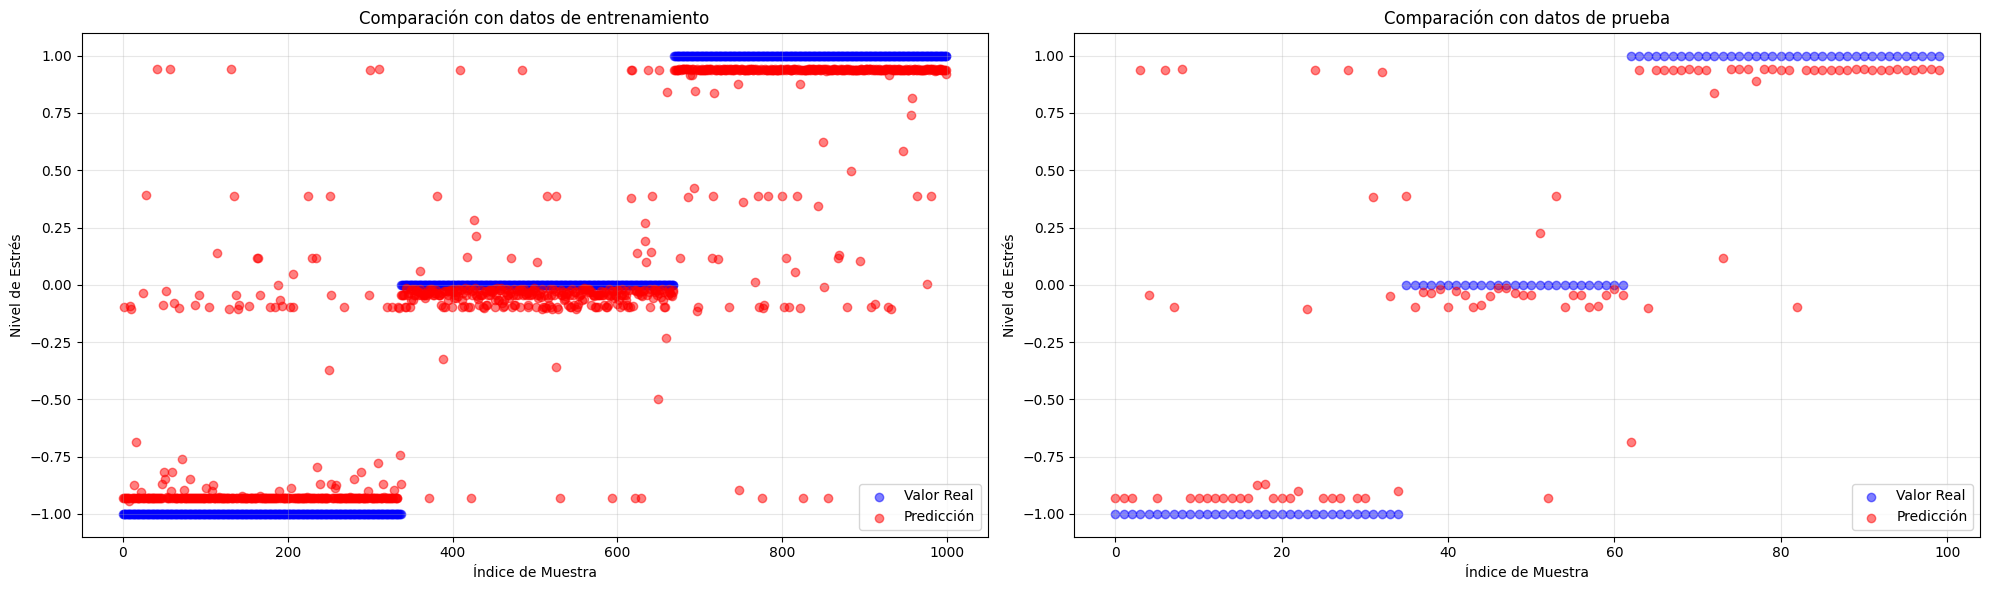

Error cuadrático medio (entrenamiento): 0.1233
Error cuadrático medio (prueba): 0.3552


In [34]:
# Evaluación
model.eval()
with torch.no_grad():
    # Predicciones de entrenamiento
    X_train_tensor = torch.FloatTensor(X_train)
    y_pred_train = model(X_train_tensor).numpy()
    
    # Predicciones de prueba
    X_test_tensor = torch.FloatTensor(X_test)
    y_pred_test = model(X_test_tensor).numpy()

# Visualización
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Gráfica de entrenamiento
train_indices = np.argsort(y_train.flatten())
ax1.scatter(range(len(y_train)), y_train[train_indices], c='blue', label='Valor Real', alpha=0.5)
ax1.scatter(range(len(y_pred_train)), y_pred_train[train_indices], c='red', label='Predicción', alpha=0.5)
ax1.set_xlabel('Índice de Muestra')
ax1.set_ylabel('Nivel de Estrés')
ax1.set_title('Comparación con datos de entrenamiento')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica de prueba
test_indices = np.argsort(y_test.flatten())
ax2.scatter(range(len(y_test)), y_test[test_indices], c='blue', label='Valor Real', alpha=0.5)
ax2.scatter(range(len(y_pred_test)), y_pred_test[test_indices], c='red', label='Predicción', alpha=0.5)
ax2.set_xlabel('Índice de Muestra')
ax2.set_ylabel('Nivel de Estrés')
ax2.set_title('Comparación con datos de prueba')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Métricas de error
mse_train = np.mean((y_train - y_pred_train)**2)
mse_test = np.mean((y_test - y_pred_test)**2)
print(f"Error cuadrático medio (entrenamiento): {mse_train:.4f}")
print(f"Error cuadrático medio (prueba): {mse_test:.4f}")

In [ ]:
# X = torch.rand(1, 28, 28, device=device)
# logits = model(X)
# pred_probab = nn.Softmax(dim=1)(logits)
# y_pred = pred_probab.argmax(1)
# print(f"Predicted class: {y_pred}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (28x28 and 5x8)